In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q -U tfx
    print("You can safely ignore the package incompatibility errors.")

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 13.3.3 Kerasの前処理層

### Core 前処理層

##### TextVectorization 層: raw 文字列を Embedding 層や Dense 層で読めるエンコードされた表現に変えます。
##### Normalization 層: 入力特徴の特徴単位の正規化を遂行します。

### 構造化データ前処理層 これらの層は構造化データ・エンコーディングと特徴エンジニアリングのためです。

##### CategoryEncoding 層: 整数カテゴリカル特徴を one-hot, マルチ-hot あるいは TF-IDF dense 表現に変えます。
##### Hashing 層: 「ハッシュトリック (= hashing trick)」としても知られる、カテゴリカル特徴ハッシングを遂行します。
##### Discretization (離散化) 層: 連続数値特徴を整数カテゴリカル特徴に変えます。
##### StringLookup 層: 文字列カテゴリカル値を整数インデックスに変えます。
##### IntegerLookup 層: 整数カテゴリカル値を整数インデックスに変えます。
##### CategoryCrossing 層: カテゴリカル特徴を共起 (= co-occurrence) 特徴に結びつけます。 E.g. 特徴値 “a” と “b” を持つ場合、それは組合せ特徴 “a と b は同時に存在する” を提供できます。



In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
 
data = np.array([[0.1, 0.2, 0.3], [0.8, 0.9, 1.0], [1.5, 1.6, 1.7],])


In [3]:
data

array([[0.1, 0.2, 0.3],
       [0.8, 0.9, 1. ],
       [1.5, 1.6, 1.7]])

In [4]:
pipeline = preprocessing.Normalization()
pipeline.adapt(data)
normalized_data = pipeline(data)
 
print("Features mean: %.2f" % (normalized_data.numpy().mean()))
print("Features std: %.2f" % (normalized_data.numpy().std()))



Features mean: -0.00
Features std: 1.00


In [5]:
data = [
    "ξεῖν᾽, ἦ τοι μὲν ὄνειροι ἀμήχανοι ἀκριτόμυθοι",
    "γίγνοντ᾽, οὐδέ τι πάντα τελείεται ἀνθρώποισι.",
    "δοιαὶ γάρ τε πύλαι ἀμενηνῶν εἰσὶν ὀνείρων:",
    "αἱ μὲν γὰρ κεράεσσι τετεύχαται, αἱ δ᾽ ἐλέφαντι:",
    "τῶν οἳ μέν κ᾽ ἔλθωσι διὰ πριστοῦ ἐλέφαντος,",
    "οἵ ῥ᾽ ἐλεφαίρονται, ἔπε᾽ ἀκράαντα φέροντες:",
    "οἱ δὲ διὰ ξεστῶν κεράων ἔλθωσι θύραζε,",
    "οἵ ῥ᾽ ἔτυμα κραίνουσι, βροτῶν ὅτε κέν τις ἴδηται.",
]
pipeline = preprocessing.TextVectorization()
pipeline.adapt(data)
vectorized_text =pipeline(data)
print(vectorized_text)

tf.Tensor(
[[37 12 25  5  9 20 21  0  0]
 [51 34 27 33 29 18  0  0  0]
 [49 52 30 31 19 46 10  0  0]
 [ 7  5 50 43 28  7 47 17  0]
 [24 35 39 40  3  6 32 16  0]
 [ 4  2 15 14 22 23  0  0  0]
 [36 48  6 38 42  3 45  0  0]
 [ 4  2 13 41 53  8 44 26 11]], shape=(8, 9), dtype=int64)


## TF Transform

### TF Transformは、取り込んだデータセットを機械学習モデルの学習で利用できるデータに変換するためのコンポーネントです
### これは、ApachBeamなどのツールを使う時に有効


### Apach Beamとは、複数のデータサーバに分散しているバッチとストリーミングの両方のデータを並列処理パイプラインを作ることができるツール

### https://cloud.google.com/dataflow/docs/guides/interactive-pipeline-development?hl=ja Appach Beamの開発に関して

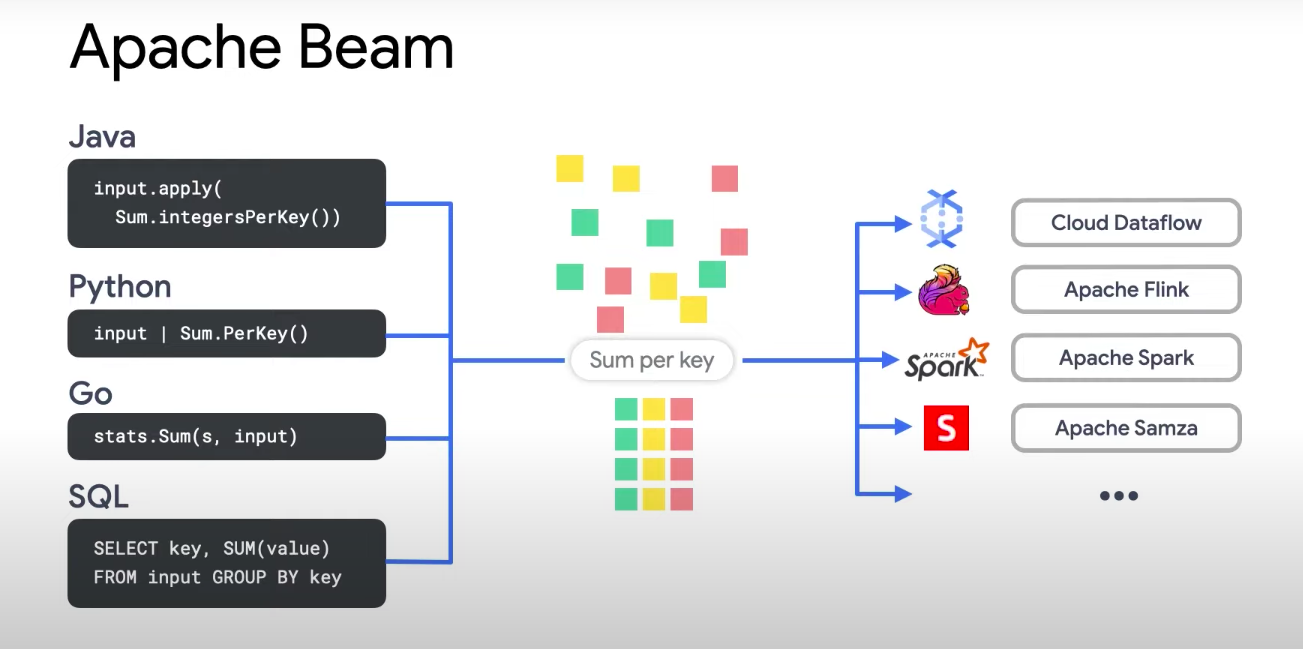

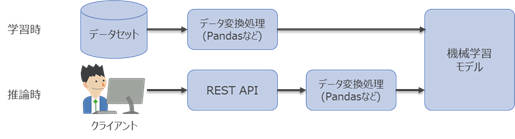
### モデルの学習に用いるデータはpandasなどを利用してデータ変換処理を実施します。このモデルをREST APIとして本番環境にデプロイする場合、モデル学習時のデータ変換処理と推論時のデータ変換処理が常に一致していることが前提となり、その確認と調整が必要になります。

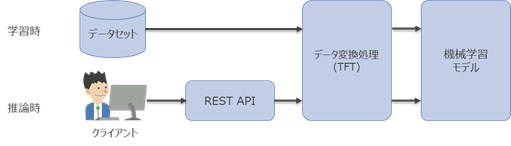
### TF Transformを用いると、学習済みのモデルと一緒にエクスポートできるため推論時と学習時の前処理の不一致となる問題が防げる

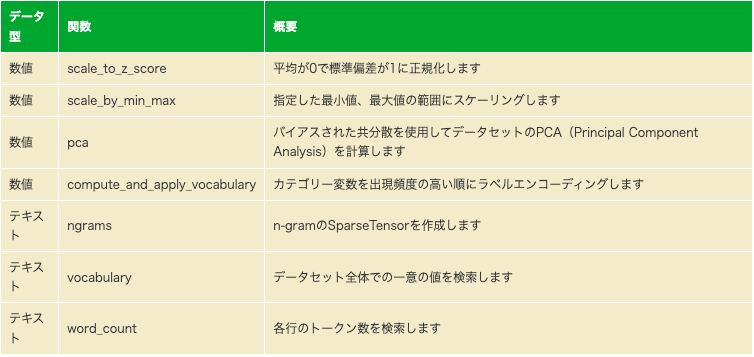

In [6]:
import tensorflow_transform as tft

def preprocess(inputs):
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age)
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age" : standardized_age,
        "ocean_proximity_id":ocean_proximity_id
    }

## TFDSプロジェクト
### MNISTやFashino MNISTのようなデータセットを利用できるようにしている
### TFDSを利用するには、tensorflow-datasetsライブラリをインストールする必要がある。

In [7]:
import tensorflow_datasets as tfds

In [8]:
dataset = tfds.load(name="mnist")

In [9]:
mnist_train,mnist_test = dataset["train"],dataset["test"]

In [10]:
mnist_train = mnist_train.shuffle(10000).batch(32).prefetch(1)

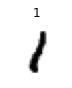

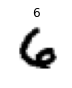

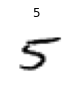

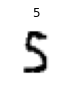

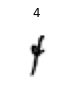

In [11]:
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
        plt.show()
    break

### kerasは、ここの要素が２要素タプルになっていることが前提となって動く。今の、datasetは、特徴量とラベルの両方を含む辞書型になっている。２要素のdatasetに変換をする。

In [12]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


### load（）関数を使ってdatasetを作る際に変換する
#### as_supervised = Trueと設定することで、可能になる

In [13]:
datasets = tfds.load(name="mnist",batch_size=32, as_supervised=True)
datasets

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>}

In [14]:
mnist_train = dataset["train"].prefetch(1)

In [15]:
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 31.8888 - accuracy: 0.8439
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 25.4994 - accuracy: 0.8697
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.8555 - accuracy: 0.8729
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.5776 - accuracy: 0.8746
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 24.0633 - accuracy: 0.8776
